# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.

It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [1]:
import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import gssi_experiment.util.util as util

pincirollis_data_path = (
    "/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/multi_N25.csv"
)
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/results/pinciroli_replication_1/"

## Dataframe creation


In [2]:
import gssi_experiment.util.prometheus_raw_data_helper as prom_data_helper


TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["gw", "s1", "s2", "s3"]


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=3
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate s3 intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(os.path.dirname(experiment_folder)).split("_")[0])
        offload = int(os.path.basename(experiment_folder).split("_")[0])
        dashboard_intensity = step / max_steps

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            dashboard_intensity,
            avg_latency,
            cpu_limit,
            replicas,
            offload,
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    "dashboard_intensity",
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
    "offload",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df

Retrying to calculate averages with services: ['gw', 's1', 's2', 's3.1']
Retrying to calculate averages with services: ['gw.1', 's1', 's2', 's3']
Retrying to calculate averages with services: ['gw.1', 's1', 's2', 's3']


,step,max_step,dashboard_intensity,avg_latency_ms,cpu_limit,replicas,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3
0,0,5,0.0,2411.454454,1000m,1,0,0.046376,0.001915,0.701626,0.883162
1,0,5,0.0,2024.691983,1000m,1,10,0.701998,0.001889,0.862457,0.342617
2,0,5,0.0,2004.302335,1000m,1,4,0.304066,0.001912,0.867927,0.747596
3,0,5,0.0,2043.478316,1000m,1,6,0.434577,0.001893,0.861121,0.598721
4,0,5,0.0,2037.712044,1000m,1,8,0.579106,0.002047,0.859499,0.486995
5,1,5,0.2,1987.101323,1000m,1,0,0.056339,0.261244,0.632061,0.809637
6,1,5,0.2,1740.210297,1000m,1,10,0.813310,0.307636,0.728290,0.305915
7,1,5,0.2,1619.921959,1000m,1,4,0.400111,0.345268,0.885234,0.836196
8,1,5,0.2,1641.264274,1000m,1,6,0.508511,0.311695,0.823074,0.588343
9,1,5,0.2,1647.990709,1000m,1,8,0.744966,0.319714,0.800361,0.448191


In [3]:
pinc_df = synth_df[["N_A", "r_gw", "R0", "Us1", "Us2", "Us3", "Ugw"]]

# Calculates offload to merge with.
pinc_df["offload"] = pinc_df["r_gw"].transform(lambda x: int(1 / x))
pinc_df = pinc_df.drop("r_gw", axis=1)

# Calculates s3 intensity to merge with.
pinc_df.loc[:, "dashboard_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on=["dashboard_intensity", "offload"])

df

/tmp/ipykernel_70296/3107786776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df["offload"] = pinc_df["r_gw"].transform(lambda x: int(1 / x))


,step,max_step,dashboard_intensity,avg_latency_ms,cpu_limit,replicas,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Us1,Us2,Us3,Ugw
0,0,5,0.0,2411.454454,1000m,1,0,0.046376,0.001915,0.701626,0.883162,375.018656,0.000000,0.799797,0.996558,1.029954e-20
1,0,5,0.0,2024.691983,1000m,1,10,0.701998,0.001889,0.862457,0.342617,253.088133,0.000000,0.200001,0.494500,9.999953e-01
2,0,5,0.0,2004.302335,1000m,1,4,0.304066,0.001912,0.867927,0.747596,276.524876,0.000000,0.726797,0.996429,3.620606e-01
3,0,5,0.0,2043.478316,1000m,1,6,0.434577,0.001893,0.861121,0.598721,225.796271,0.000000,0.659358,0.992064,6.554911e-01
4,0,5,0.0,2037.712044,1000m,1,8,0.579106,0.002047,0.859499,0.486995,207.394334,0.000000,0.485361,0.852991,9.607230e-01
5,1,5,0.2,1987.101323,1000m,1,0,0.056339,0.261244,0.632061,0.809637,245.104436,0.713907,0.803877,0.988264,8.128606e-20
6,1,5,0.2,1740.210297,1000m,1,10,0.813310,0.307636,0.728290,0.305915,249.890258,0.199297,0.158619,0.398522,9.998901e-01
7,1,5,0.2,1619.921959,1000m,1,4,0.400111,0.345268,0.885234,0.836196,197.840939,0.586531,0.713832,0.983678,5.041384e-01
8,1,5,0.2,1641.264274,1000m,1,6,0.508511,0.311695,0.823074,0.588343,181.560459,0.477255,0.613766,0.939101,8.225972e-01
9,1,5,0.2,1647.990709,1000m,1,8,0.744966,0.319714,0.800361,0.448191,202.680325,0.311383,0.390358,0.685479,9.905588e-01


# Request Delay


## Visualization


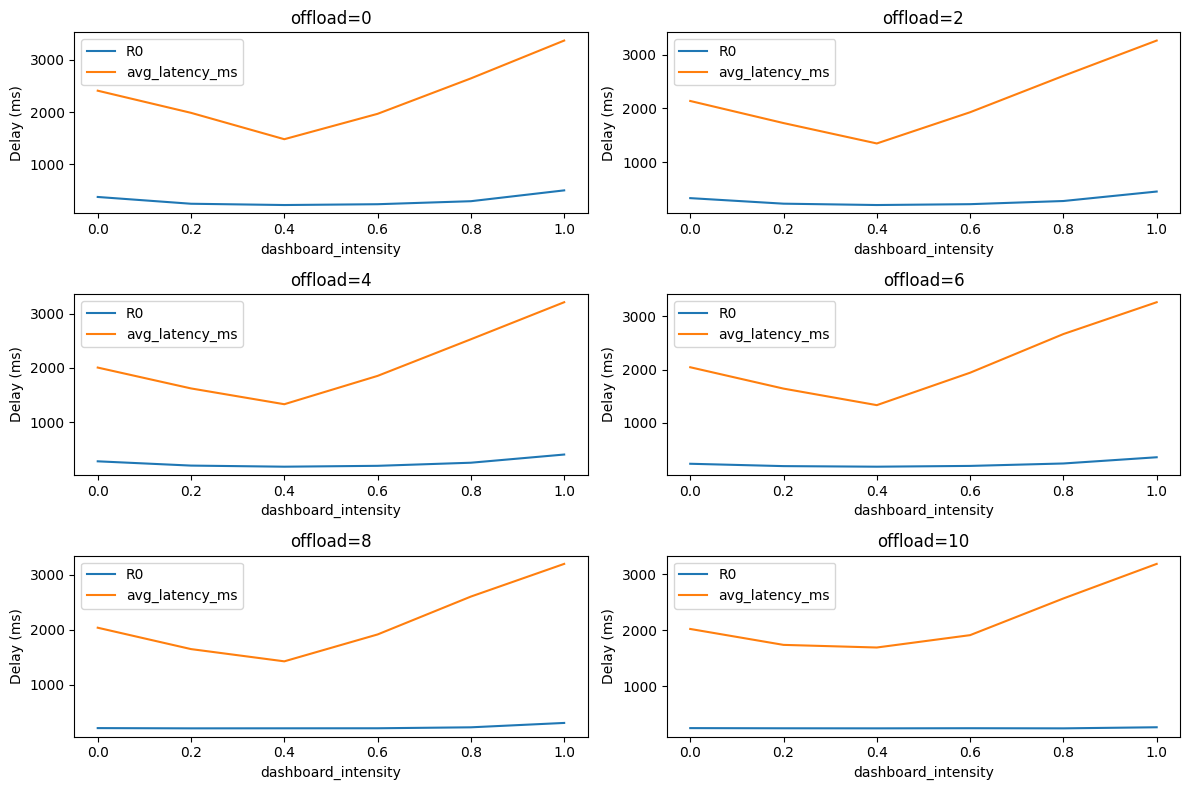

In [4]:
def create_fig_3(
    df: pd.DataFrame, y_keys: typing.List[str], x_key: str, split_key: str, y_label: str
):
    splits = df[split_key].unique()
    splits.sort()
    num_subplots = len(splits)

    num_rows = num_subplots // 2
    num_cols = 2
    _, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, split in enumerate(splits):
        tmp_df = df[df[split_key] == split]
        ax = axes[i]

        tmp_df = tmp_df.sort_values(x_key)
        for y_key in y_keys:
            tmp_df.plot(x_key, y_key, ax=ax)

        ax.set_xlabel(x_key)
        ax.set_ylabel(y_label)
        ax.set_title(f"{split_key}={split}")

    plt.tight_layout()
    plt.show()


def create_fig_2(
    df: pd.DataFrame,
    synth_key: str,
    real_key: str,
    split_key: str,
    y_label: str,
    x_label: str = "Dashboard Intensity",
):
    splits = df[split_key].unique()
    splits.sort()
    num_subplots = len(splits)

    num_rows = num_subplots // 2
    num_cols = 2
    _, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, split in enumerate(splits):
        tmp_df = df[df[split_key] == split]
        ax = axes[i]

        x_column = "dashboard_intensity"
        tmp_df = tmp_df.sort_values(x_column)
        tmp_df.plot(x_column, synth_key, ax=ax)
        tmp_df.plot(x_column, real_key, ax=ax)
        ax[i].title.set_text(split)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

    plt.tight_layout()
    plt.show()


create_fig_3(
    df, ["R0", "avg_latency_ms"], "dashboard_intensity", "offload", "Delay (ms)"
)

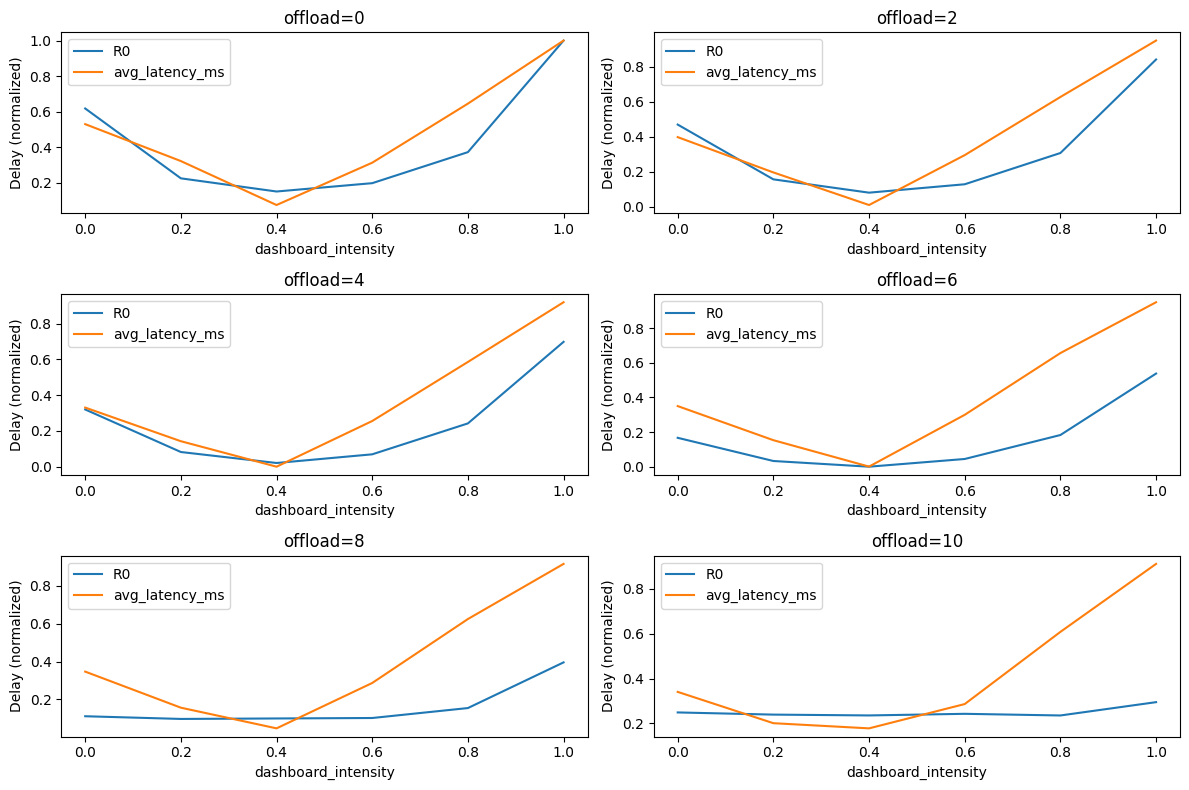

In [5]:
# Normalized data


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm["dashboard_intensity"] = df["dashboard_intensity"]
df_norm["offload"] = df["offload"]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


create_fig_3(
    df_norm,
    ["R0", "avg_latency_ms"],
    "dashboard_intensity",
    "offload",
    "Delay (normalized)",
)

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [6]:
def mape(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele) / expected_ele)
    m /= len(expected)
    return m


absolute_mape = mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=}, {normalized_mape=} ({eps=})")

absolute_mape=0.879768790847661, normalized_mape=0.11676888903975456 (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [7]:
def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=}, {normalized_mae=}")

absolute_mae=1917.4696565502506, normalized_mae=0.1792650265765067


# Visualizing the relationship


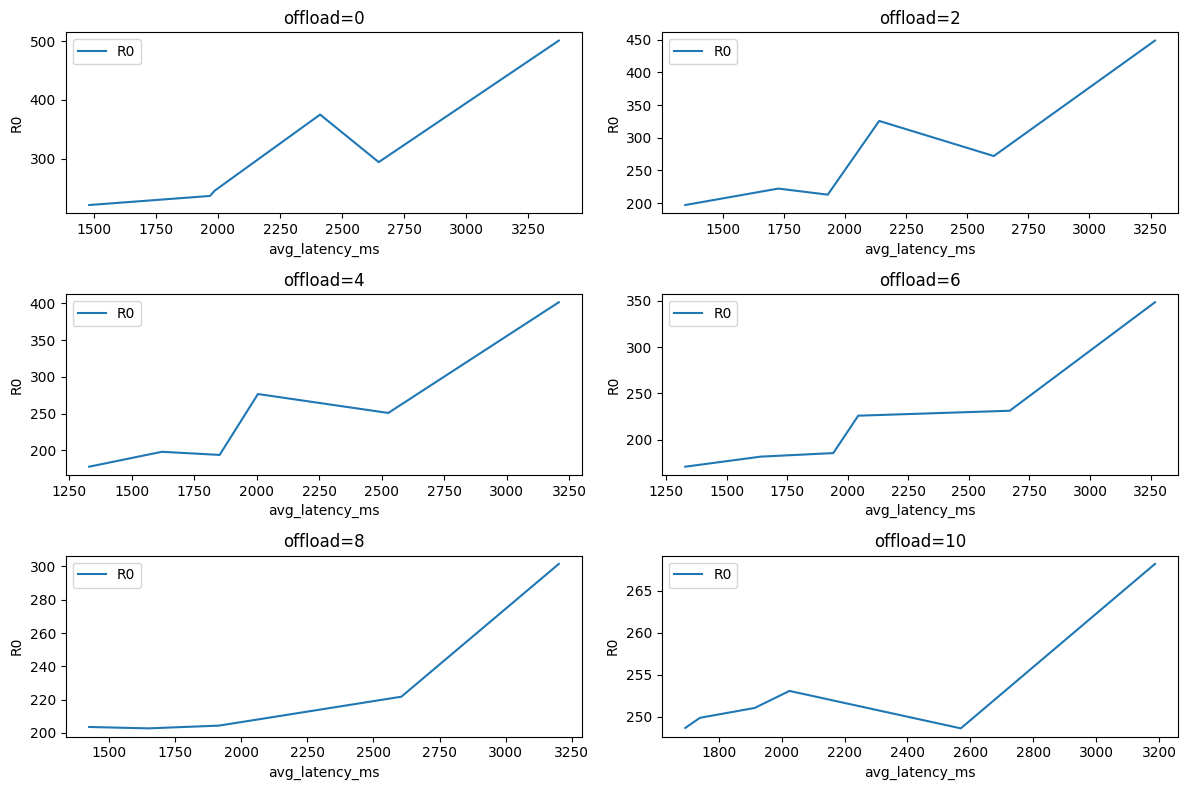

In [8]:
create_fig_3(df, ["R0"], "avg_latency_ms", "offload", y_label="R0")

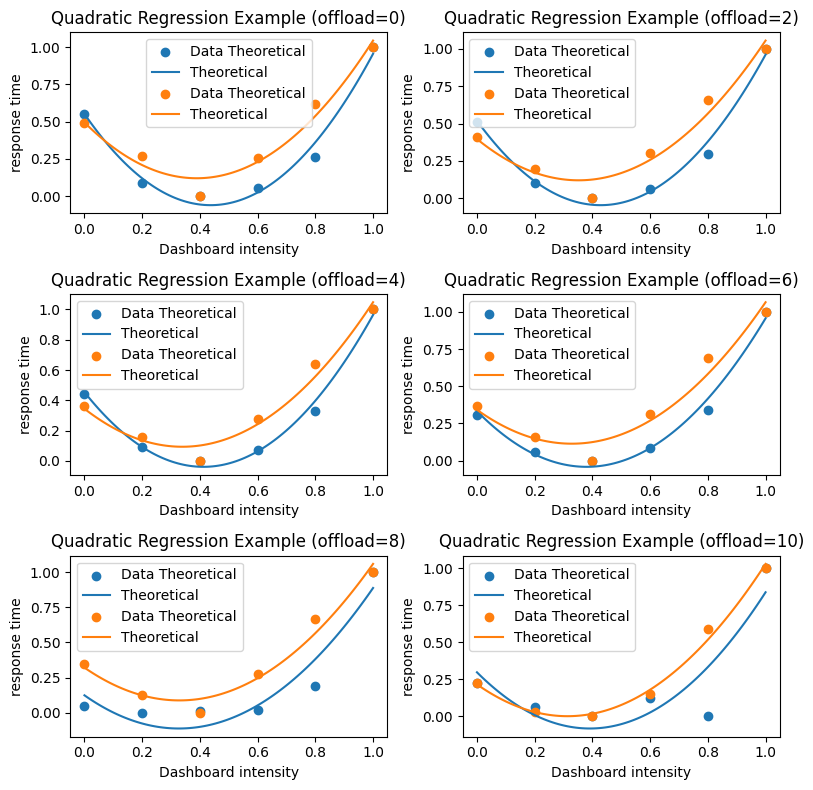

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def normalize_field(df: pd.DataFrame, field: str) -> pd.DataFrame:
    min_x, max_x = min(df[field]), max(df[field])
    df.loc[:, field] = df[field].transform(lambda x: normalize(x, min_x, max_x))
    return df


def make_model(x, y):
    # Fit a quadratic regression model
    coefficients = np.polyfit(x, y, 2)
    quadratic_model = np.poly1d(coefficients)

    # Generate y values from the model for smooth plotting
    x_smooth = np.linspace(min(x), max(x), 100)
    y_smooth = quadratic_model(x_smooth)
    return x_smooth, y_smooth


def visualize_plots(df: pd.DataFrame, y_keys: str, split_key: str):
    splits = df[split_key].unique()
    splits.sort()
    num_subplots = len(splits)

    num_rows = num_subplots // 2
    num_cols = 2
    _, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, split in enumerate(splits):
        tmp_df = df[df[split_key] == split]
        ax = axes[i]

        tmp_df = normalize_field(tmp_df, "R0")
        tmp_df = normalize_field(tmp_df, "avg_latency_ms")

        x = tmp_df["dashboard_intensity"].tolist()

        for y_key in y_keys:
            y = tmp_df[y_key].tolist()
            x_smooth, y_smooth = make_model(x, y)

            ax.scatter(x, y, label="Data Theoretical")
            ax.plot(x_smooth, y_smooth, label="Theoretical")
            ax.set_xlabel("Dashboard intensity")
            ax.set_ylabel("response time")
            ax.set_title(f"Quadratic Regression Example ({split_key}={split})")
            ax.legend()

    plt.tight_layout()
    plt.show()


visualize_plots(df, ["R0", "avg_latency_ms"], "offload")

# CPU Utilization


## Visualization


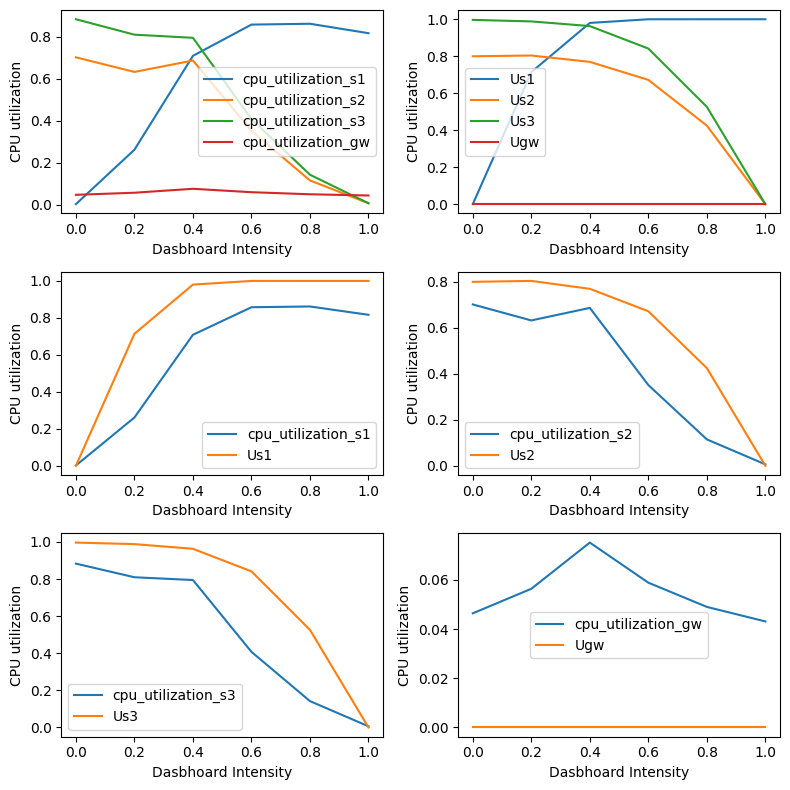

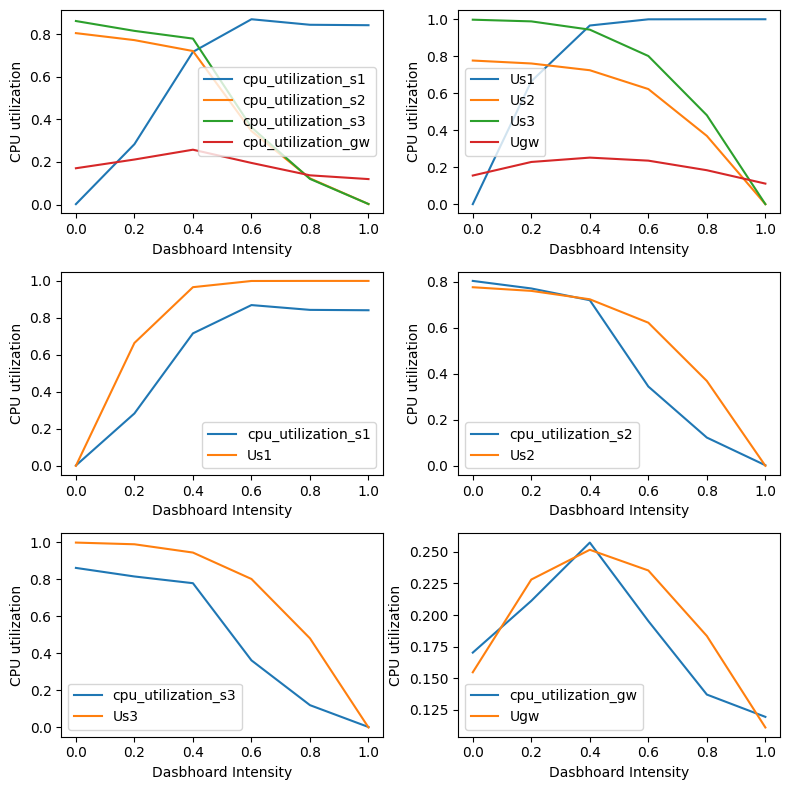

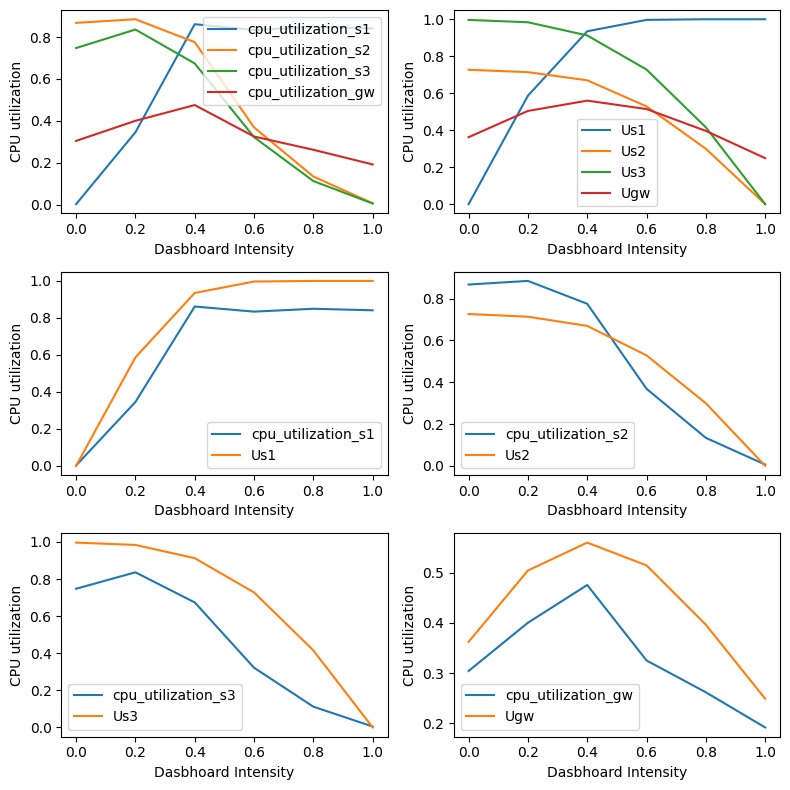

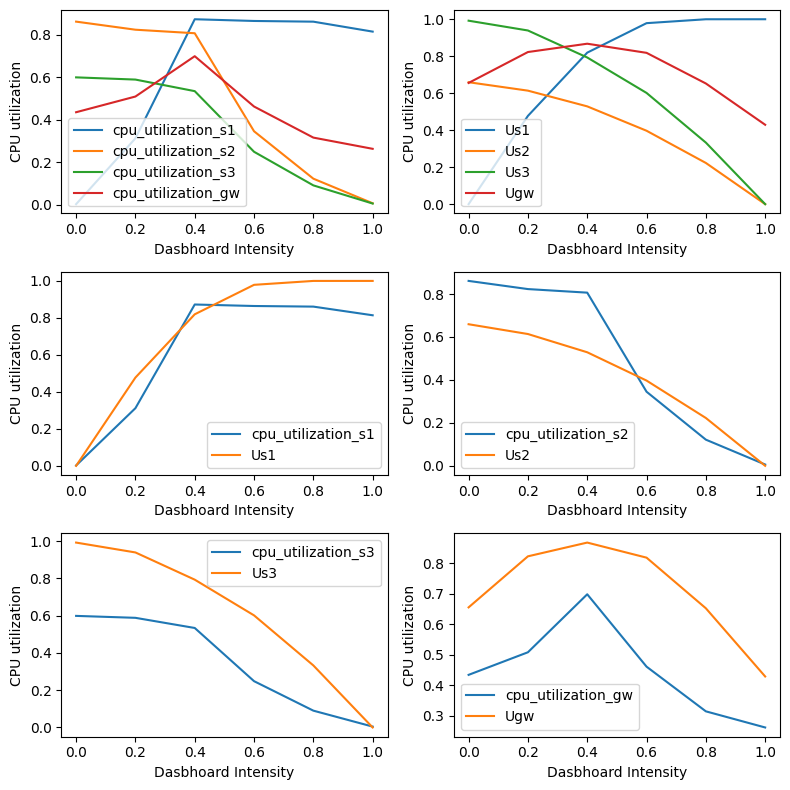

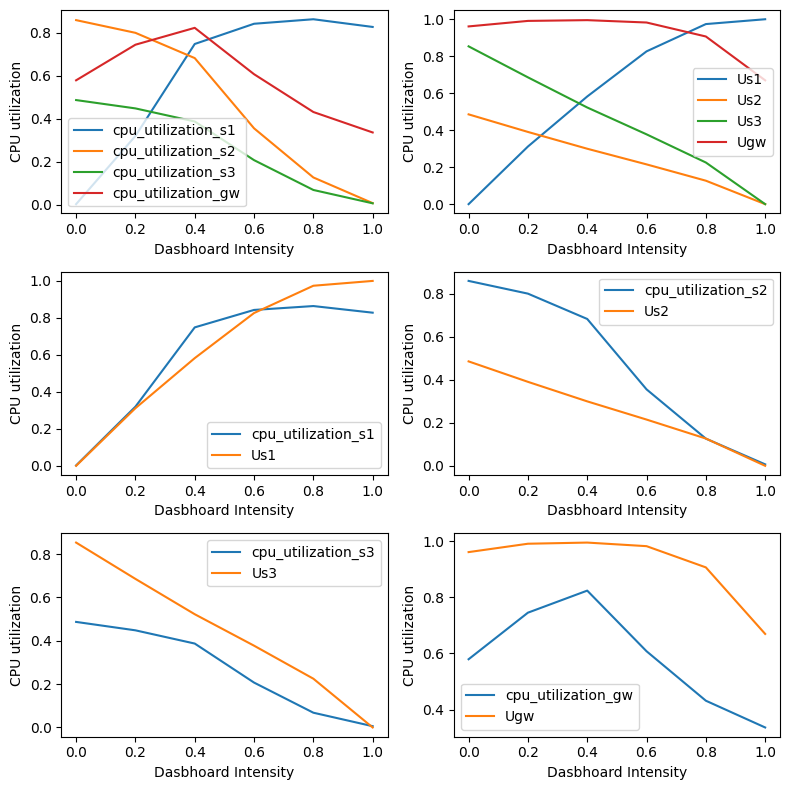

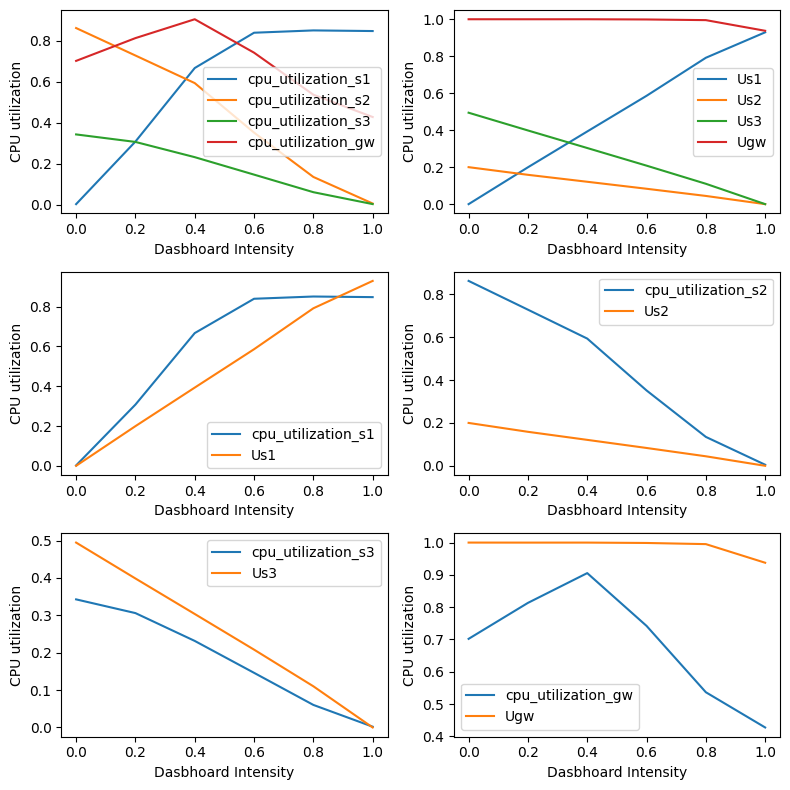

In [10]:
def plot_comparisons(comparison_tuples, df):
    # Calculate the number of subplots based on the length of comparison_tuples
    num_subplots = len(comparison_tuples)
    # Determine the number of rows and columns for the subplots
    num_rows = num_subplots // 2  # Assuming 2 columns
    num_cols = 2  # Number of columns for the subplots

    # Create a larger figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

    # Flatten the axes array if there is more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, columns in enumerate(comparison_tuples):
        # Select the current subplot
        ax = axes[i]

        # Plot a line diagram for each pair of columns in the DataFrame
        x_column = "dashboard_intensity"
        for column in columns:
            df.plot(x=x_column, y=column, ax=ax)

        ax.set_xlabel("Dasbhoard Intensity")
        ax.set_ylabel("CPU utilization")

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()


comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gw",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

split_key = "offload"
splits = df[split_key].unique()
splits.sort()

for split in splits:
    sub_df = df[df[split_key] == split]
    sub_df = sub_df.sort_values("dashboard_intensity")
    plot_comparisons(comparison_tuples, sub_df)

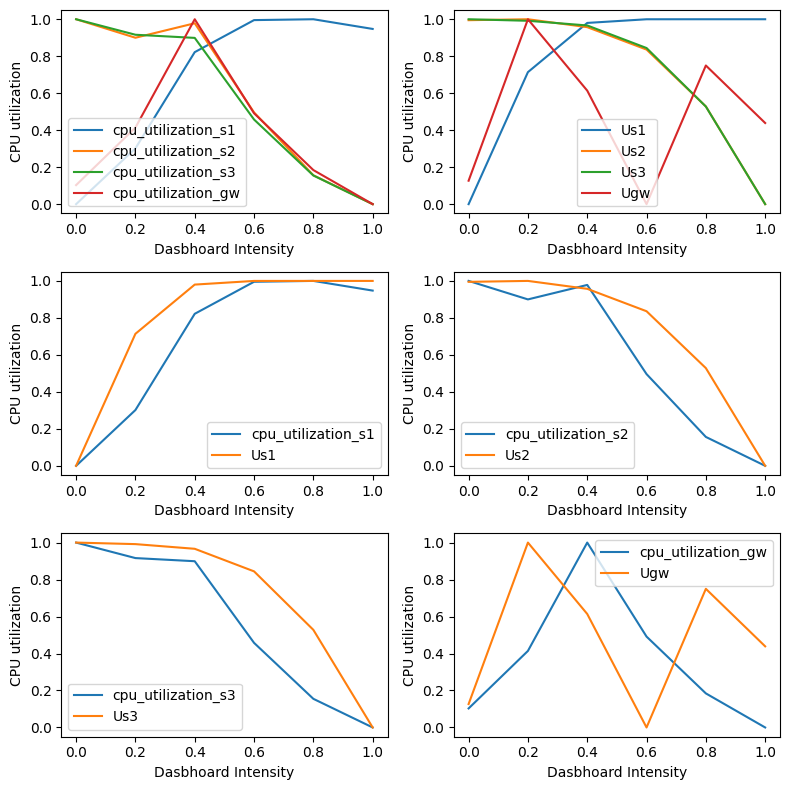

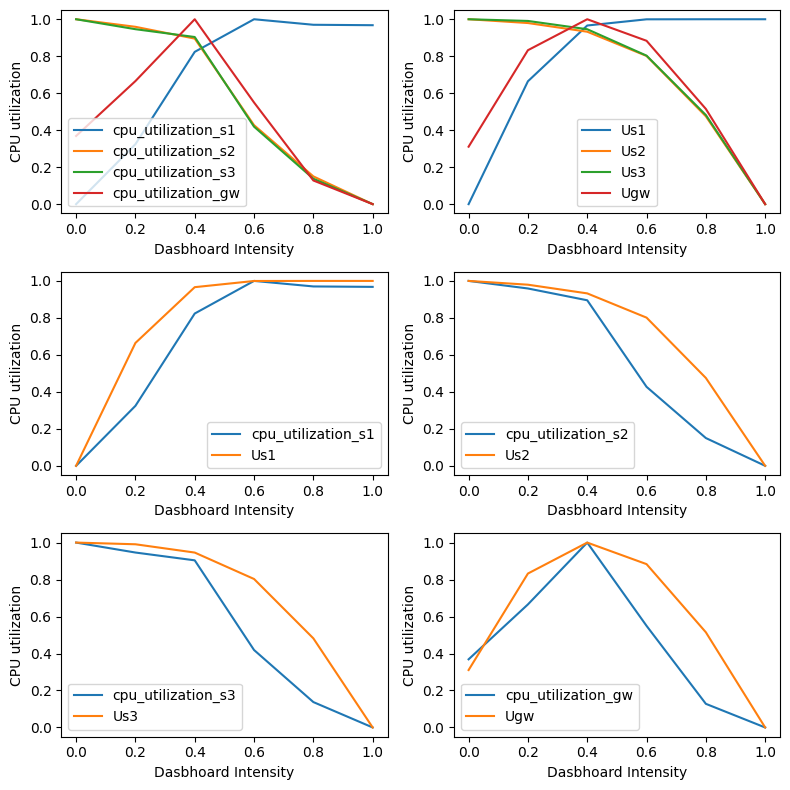

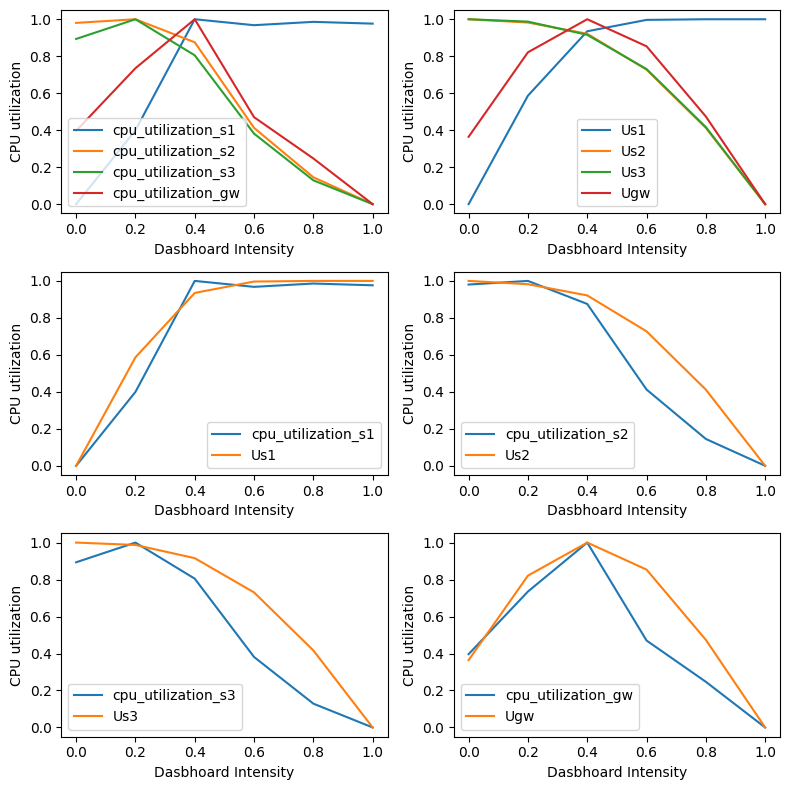

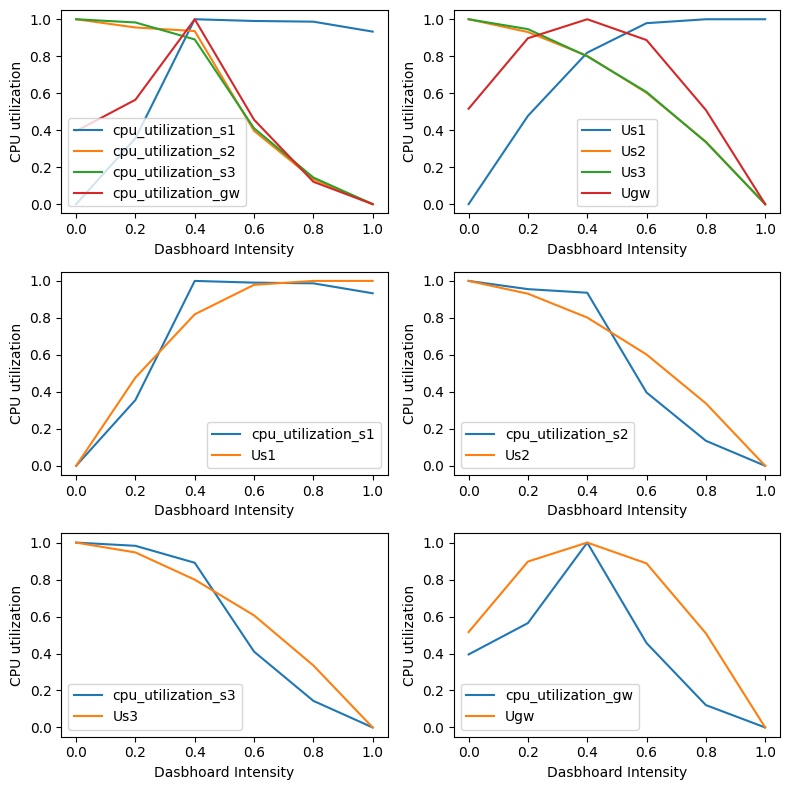

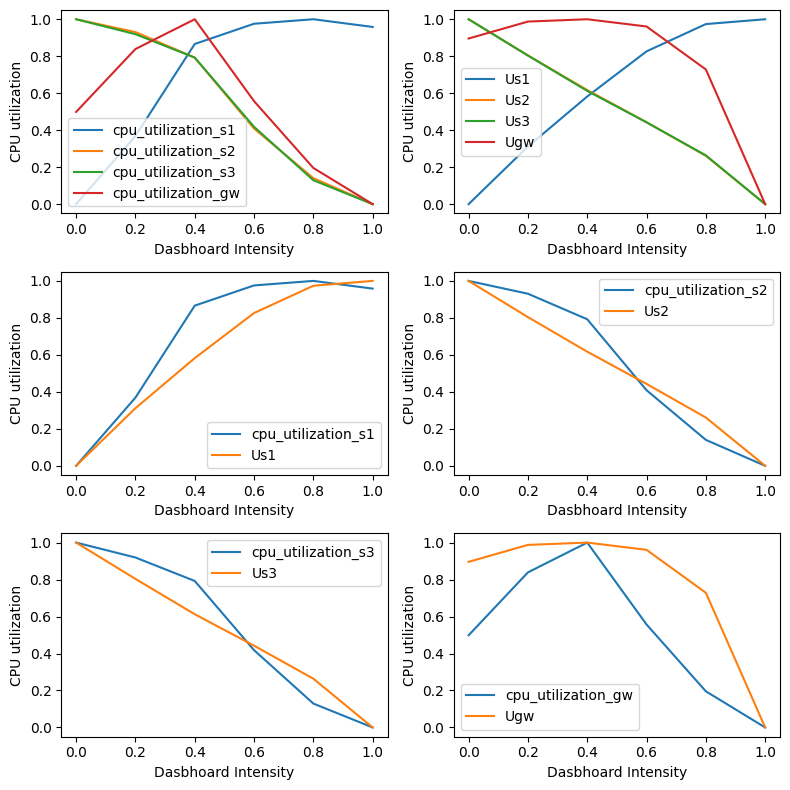

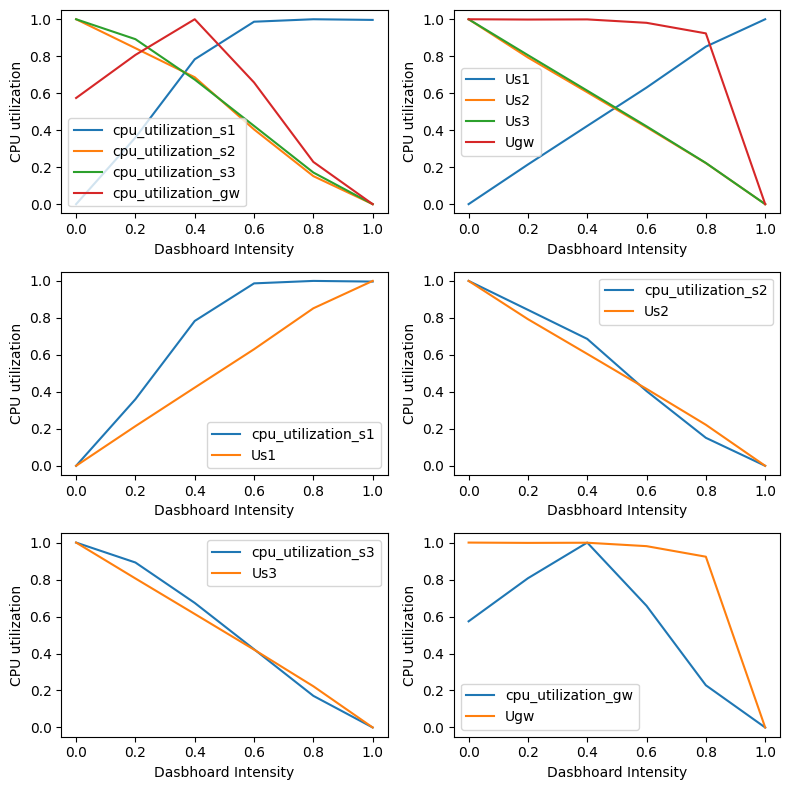

In [11]:
norm_df = pd.DataFrame()

for col in df.select_dtypes(include="number").columns:
    min_x, max_x = min(df[col]), max(df[col])
    norm_df[col] = df[col].transform(lambda x: normalize(x, min_x, max_x))


comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gw",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]


def iterate_through_nested_iterators(iterator: typing.Iterator):
    for ele in iterator:
        if isinstance(ele, typing.Iterator) or isinstance(ele, typing.Tuple):
            for q in iterate_through_nested_iterators(ele):
                yield q
        else:
            yield ele


used_keys = set(iterate_through_nested_iterators(comparison_tuples))


split_key = "offload"
splits = df[split_key].unique()
splits.sort()

for split in splits:
    sub_df = df[df[split_key] == split]
    sub_df = sub_df.sort_values("dashboard_intensity")
    for key in used_keys:
        sub_df = normalize_field(sub_df, key)
    plot_comparisons(comparison_tuples, sub_df)

## Evaluation


In [12]:
comparison_tuples = [
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

### Spearman's correlation coefficient


In [13]:
split_key = "offload"
splits = df[split_key].unique()
splits.sort()

for split in splits:
    print()
    print(f"{split=}")
    sub_df = df[df[split_key] == split]

    for real, expected in comparison_tuples:
        correlation_coefficient, p_value = spearmanr(sub_df[expected], sub_df[real])

        # Display the result
        print(
            f"Spearman's correlation coefficient {real}: {correlation_coefficient} ({p_value=})"
        )


split=0
Spearman's correlation coefficient cpu_utilization_s1: 0.898645105261295 (p_value=0.014888622005580348)
Spearman's correlation coefficient cpu_utilization_s2: 0.8285714285714287 (p_value=0.04156268221574334)
Spearman's correlation coefficient cpu_utilization_s3: 1.0 (p_value=0.0)
Spearman's correlation coefficient cpu_utilization_gw: 0.08571428571428573 (p_value=0.8717434402332361)

split=2
Spearman's correlation coefficient cpu_utilization_s1: 0.8116794499134278 (p_value=0.04985758510134042)
Spearman's correlation coefficient cpu_utilization_s2: 1.0 (p_value=0.0)
Spearman's correlation coefficient cpu_utilization_s3: 1.0 (p_value=0.0)
Spearman's correlation coefficient cpu_utilization_gw: 0.8857142857142858 (p_value=0.01884548104956266)

split=4
Spearman's correlation coefficient cpu_utilization_s1: 0.6377481392176932 (p_value=0.17307111024125976)
Spearman's correlation coefficient cpu_utilization_s2: 0.942857142857143 (p_value=0.004804664723032055)
Spearman's correlation coe

### Mean average (percentage) error


In [14]:
split_key = "offload"
splits = df[split_key].unique()
splits.sort()

for split in splits:
    print()
    print(f"{split=}")
    sub_df = df[df[split_key] == split]
    sub_norm_df = norm_df[norm_df[split_key] == split]

    for real, expected in comparison_tuples:
        mape_score = mape(sub_df[expected], sub_df[real])
        mae_score = mae(sub_df[expected], sub_df[real])
        print(f"{real}: {mape_score=}, {mae_score=}")

        eps = 1
        # norm_mape_score = mape(sub_norm_df[expected] + eps, sub_norm_df[real] + eps)
        try:
            norm_mae_score = mae(sub_norm_df[expected], sub_norm_df[real])
            print(f"{real}: ({eps=}), {norm_mae_score=}")
        except:
            pass

        print()


split=0
cpu_utilization_s1: mape_score=0.611075110003171, mae_score=0.19830372624257886
cpu_utilization_s1: (eps=1), norm_mae_score=0.11282867612395774

cpu_utilization_s2: mape_score=0.8574204259772911, mae_score=0.16499679893270489
cpu_utilization_s2: (eps=1), norm_mae_score=0.2530511729989541

cpu_utilization_s3: mape_score=0.8880390047630934, mae_score=0.21407587322195576
cpu_utilization_s3: (eps=1), norm_mae_score=0.14954307106162376

cpu_utilization_gw: mape_score=1.0, mae_score=0.054783853870242004
cpu_utilization_gw: (eps=1), norm_mae_score=0.013574511576711244


split=2
cpu_utilization_s1: mape_score=0.5365370249307733, mae_score=0.17978142514211246

cpu_utilization_s2: mape_score=0.6439517318964173, mae_score=0.09472388681479736

cpu_utilization_s3: mape_score=0.9650098292912315, mae_score=0.21293258265263235

cpu_utilization_gw: mape_score=0.1344198138766592, mae_score=0.022143515588547585


split=4
cpu_utilization_s1: mape_score=0.39091200290528966, mae_score=0.13148302563